**Modelo de red neuronal Transformer**

Este archivo consta de los codigos y conclusiones de:
* 1.Carga de librerias y datos
* 2.Normalizar Datos.
* 3.Preparar datos para realizar aprendizaje supervizado.
* 4.Modelo Transformer
* 5.Evaluacion del modelo


#1.Carga de Librerias y Datos


*Se importan los módulos necesarios para trabajar*

In [2]:
#Pandas es utilizado para leer los set de datos
import pandas as pd
#Numpy es utilizado para generar las series de datos a graficar
import numpy as np
#Seaborn es utilizado para generar los gráficos
import seaborn as sns
import matplotlib.pyplot as plt
#Se importan modulos estadisticos para generar test de hipotesis, entre otros
from sklearn.preprocessing import StandardScaler
#Módulos implementa funciones que evalúan el error de predicción para propósitos específicos
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
#Ignorar warnings
import warnings
warnings.filterwarnings("ignore")

#Dividir arreglos o matrices en subconjuntos aleatorios de tren y prueba
from sklearn.model_selection import train_test_split

#Biblioteca de Redes Neuronales
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, model_from_json
from keras.layers import Dropout, LSTM, Dense, Activation,Input
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor

from hyperopt import Trials, STATUS_OK, tpe, hp, fmin, space_eval
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict, TimeSeriesSplit
import time, random,os

In [3]:
# Para acceder a los archivos del gdrive
from google.colab import drive
drive.mount('/content/gdrive/')


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [4]:
pip install h5py --quiet

In [5]:
cd /content/gdrive/MyDrive/Tesis/Datos

/content/gdrive/MyDrive/Tesis/Datos


Se obtiene conjunto de datos

In [6]:
predictor_variables=pd.read_csv('predictor_variables.csv', index_col='Date')
target_variables=pd.read_csv('target_variables.csv', index_col='Date')
df=pd.read_csv('df_modelo.csv', index_col='Date')

In [7]:
def divide_array(array, num_parts,largo):
  i=0
  j=0
  j=largo
  series_results=[]

  x=[]
  for k in range(20):
    aux= array[i:j]
    j=largo+j
    i=i+largo
    series_results.append(aux)
    x.append(aux)

  return x

In [8]:
series=divide_array(df,20,143)
predict_series=divide_array(predictor_variables,20,142)
target_series=divide_array(target_variables,20,142)

In [9]:
#predictor_variables_serie[0].columns=["Store","Dept","Weekly_Sales","IsHoliday",	"Temperature","Fuel_Price","MarkDown1","MarkDown2"	,"MarkDown3","MarkDown4"	,"MarkDown5","CPI","Unemployment"]

##Sección nueva

In [10]:
#Setear semilla
np.random.seed(42)

In [11]:
result_gru=pd.read_csv('results_LSTM_Wallmart.csv')
result_gru = result_gru.sort_values(by='MSE', ascending=True)
result_gru.head(5)


,Unnamed: 0,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
90,90,LSTM_Wallmart_19_1_800_40.0_1.0_96.0_0.68_adam...,19,1,76.977597,0.450927,0.671511,0.524378,15345.731445
27,27,LSTM_Wallmart_6_3_800_90.0_2.0_64.0_0.59_adam_...,6,3,90.770175,0.460555,0.678642,0.526315,15564.112305
91,91,LSTM_Wallmart_19_2_800_40.0_1.0_96.0_0.68_adam...,19,2,87.723434,0.460652,0.678714,0.527428,13246.068359
88,88,LSTM_Wallmart_18_4_800_70.0_3.0_576.0_0.48_ada...,18,4,141.353467,0.461849,0.679595,0.525437,21254.886719
28,28,LSTM_Wallmart_6_4_800_90.0_2.0_64.0_0.59_adam_...,6,4,64.244036,0.461964,0.679680,0.524531,13518.825195


In [12]:
nombre_archivo=result_gru['nameModel'].iloc[0]
nombre_archivo="2LSTM_Wallmart_19_1_800_40.0_1.0_96.0_0.68_adam_4.958923243340043e-05"

In [13]:
nombre_json=nombre_archivo+"."+"json"
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos/result_LSTM'
ruta = os.path.join(carpeta_destino, nombre_json)
save_w=nombre_archivo+"."+"h5"
weights_path = os.path.join(carpeta_destino, save_w)

In [14]:
# load json and create model
json_file = open(ruta, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weights_path)
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=3.961513890566025e-05), metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()])


Loaded model from disk


##Narmax

In [15]:
#Se da formato de entradas como: Un tensor 3D con la forma [batch, timesteps, feature]
predictor_variable=[]
target_variable=[]
for serie, target in zip(predict_series,target_series):
  predictor=np.array(serie)
  predictor= predictor.reshape((serie.shape[0], 1, serie.shape[1]))
  predictor_variable.append(predictor)

  target=np.array(target)
  target_variable.append(target)
  target_shape=target.shape

In [16]:
target_shape

(142, 1)

In [17]:
def narmax_data(data,modelo,predictor,shape_target,retrasos,target):
  #Se realiza prediccion
  results = modelo.predict(predictor)
  results = results.reshape(shape_target)
  target=np.array(target_variables)

  error=[]
  aux=0
  for prediccion, real in zip(results,target):
    aux=real-prediccion
    error.append(aux[0])

  df_narmax = data.iloc[1:]
  # Agregamos el arreglo como nueva columna en el DataFrame
  df_narmax['error'] = error

  return df_narmax

In [18]:
series_time=[]
for serie,predictor,target in zip(series,predictor_variable,target_variable):
  aux=narmax_data(serie,loaded_model,predictor,target_shape,1,target)
  series_time.append(aux)


5/5 [==============================] - 0s 2ms/step


In [19]:
series_time[0]

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,error
Date,,,,,,,,,,,,,,
2010-02-12,7,9,-1.066339,3.646917,-0.837239,-1.562510,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.315544,1.000733,-0.238616
2010-02-19,7,9,-1.055308,-0.274204,-0.753638,-1.613850,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.293672,1.000733,-0.168152
2010-02-26,7,9,-1.026079,-0.274204,-0.897213,-1.529839,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.272466,1.000733,-0.354108
2010-03-05,7,9,-1.077562,-0.274204,-0.233857,-1.450495,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.251260,1.000733,-0.408571
2010-03-12,7,9,-1.053027,-0.274204,-0.755455,-1.301142,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.230053,1.000733,-0.438208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-09-28,7,9,-0.144565,-0.274204,0.661521,1.277528,0.217803,-0.230168,-0.087864,0.147478,0.106075,1.542983,-1.667791,-0.348593
2012-10-05,7,9,-0.360016,-0.274204,0.527639,1.254192,0.100890,-0.233833,-0.086302,0.784767,0.011427,1.615590,-2.403855,-0.154843
2012-10-12,7,9,-0.115887,-0.274204,0.103576,1.209853,-0.296936,-0.233833,-0.088089,-0.113224,-0.152332,1.688198,-2.403855,0.268537


#4.Preparar datos para realizar aprendizaje supervizado.

La idea es modelar cada valor en función de los valores recientes anteriores, dado un retardo de tiempo dado. **Los valores futuros de una variable en una serie de tiempo dependen de sus propios rezagos y de los rezagos de otras variables.**

In [20]:
def time_delay_embedding(series: pd.Series, n_lags: int, horizon: int):
    """
    Incrustación de retardo de tiempo
    :param series: serie de tiempo como objeto de pandas
    :param n_lags: número de valores pasados para usar como variables explicativas
    :param horizon: horizonte de pronostico
    :return:pd.DataFrame con series temporales reconstruidas
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    serie_time_delay = [series.shift(i) for i in n_lags_iter]
    serie_time_delay = pd.concat(serie_time_delay, axis=1).dropna()
    serie_time_delay.columns = [f'{name}(t-{j - 1})'
                 if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                 for j in n_lags_iter]

    return serie_time_delay

In [21]:
series_predic=[]
series_target=[]
for serie in series_time:
  serie_split = []
  for columna in serie:
    col_df = time_delay_embedding(
        serie[columna],     #Serie de tiempo
        n_lags=1,           #Numero de retrasos
        horizon=1           # Horizonte de prediccion
          )
    serie_split.append(col_df)

  serie_df = pd.concat(serie_split, axis=1).dropna()
  predictor_variables = serie_df.columns.str.contains('\(t\-')
  target_variables = serie_df.columns.str.contains('Weekly_Sales\(t\+')

  predictor_variables = serie_df.iloc[:, predictor_variables]
  target_variables = serie_df.iloc[:, target_variables]
  series_predic.append(predictor_variables)
  series_target.append(target_variables)

In [22]:
#Ejemplo de variables de prediccion de una serie
series_predic[0].head(4)

,Store(t-0),Dept(t-0),Weekly_Sales(t-0),IsHoliday(t-0),Temperature(t-0),Fuel_Price(t-0),MarkDown1(t-0),MarkDown2(t-0),MarkDown3(t-0),MarkDown4(t-0),MarkDown5(t-0),CPI(t-0),Unemployment(t-0),error(t-0)
Date,,,,,,,,,,,,,,
2010-02-19,7.0,9.0,-1.066339,3.646917,-0.837239,-1.562510,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.315544,1.000733,-0.238616
2010-02-26,7.0,9.0,-1.055308,-0.274204,-0.753638,-1.613850,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.293672,1.000733,-0.168152
2010-03-05,7.0,9.0,-1.026079,-0.274204,-0.897213,-1.529839,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.272466,1.000733,-0.354108
2010-03-12,7.0,9.0,-1.077562,-0.274204,-0.233857,-1.450495,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.251260,1.000733,-0.408571


In [23]:
#Ejemplo de variables objetivo de una serie
series_target[0].head(4)

,Weekly_Sales(t+1)
Date,
2010-02-19,-1.055308
2010-02-26,-1.026079
2010-03-05,-1.077562
2010-03-12,-1.053027


In [24]:
#Se separa conjunto en entrenamiento y prueba; sin aleatoriedad
#Dejando un %20 de la data para test
X_train=pd.DataFrame()
X_test=pd.DataFrame()
Y_train=pd.DataFrame()
Y_test=pd.DataFrame()

for serie,target in zip(series_predic,series_target):
  X_train_i, X_test_i, Y_train_i, Y_test_i = train_test_split(serie, target, test_size=0.2, shuffle=False)
  X_train=pd.concat([X_train, X_train_i])
  X_test=pd.concat([X_test, X_test_i])
  Y_train=pd.concat([Y_train, Y_train_i])
  Y_test=pd.concat([Y_test, Y_test_i])

shape_x_test=X_test.shape
shape_y_test=Y_test.shape
shape=len(X_train.columns)

print("Separacion de datos terminada!")

Separacion de datos terminada!


#5.LSTM

In [25]:
# Ajustar parámetros para reproducibilidad del entrenamiento
#tf.random.set_seed(123)
keras.utils.set_random_seed(123)
tf.config.experimental.enable_op_determinism()

In [26]:
#Se da formato de entradas como: Un tensor 3D con la forma [batch, timesteps, feature]
X_train=np.array(X_train)
X_train = X_train.reshape((X_train.shape[0],1,X_train.shape[1]))

Y_train_s=np.array(Y_train)
Y_train_s = Y_train_s.reshape((Y_train_s.shape[0],1,Y_train_s.shape[1]))

X_test=np.array(X_test)
X_test = X_test.reshape((X_test.shape[0],1,X_test.shape[1]))

Y_test=np.array(Y_test)
Y_test = Y_test.reshape((Y_test.shape[0], 1, Y_test.shape[1]))

In [27]:
# Función para crear el modelo
def create_model(neurons, dropout,layers,learning_rate):

    #Creacion de la arquitectura LSTM
    model = Sequential()
    #Capas ocultas
    for i in range(layers):
        model.add(LSTM(units=neurons, return_sequences=(layers-1), input_shape=(X_train.shape[1],X_train.shape[2]) ))
        model.add(Dropout(dropout))
    #Capa de salida
    model.add(Dense(1))

    #Se configura el proceso de entrenamiento del modelo y metricas de evaluacion
    model.compile(loss='mean_squared_error',
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()]
                  )
    return model

In [28]:
def objective(params):

    # Definir los hiperparámetros a optimizar
    epochs = params['epochs']
    batch_size = params['batch_size']
    optimizer = params['optimizer']
    neurons  = params['neurons']
    dropout  = params['dropout']
    layers  = params['layers']
    learning_rate = params['learning_rate']



    #kf = KFold(n_splits=5)
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []
    times=[]
    models=[]
    scores_test=[]

    #Se detiene el entrenamiento en el momento que se observe un incremento en el valor del error de validación.
    early_stop = EarlyStopping(monitor='val_loss', patience=30, mode='min',restore_best_weights=True)

    #Validacion cruzada
    for train_index, test_index in tscv.split(X_train):
      X_train_, X_test_ = X_train[train_index], X_train[test_index]
      y_train_, y_test_ = Y_train_s[train_index], Y_train_s[test_index]

      # Crear el modelo de LSTM
      model = create_model(int(neurons), float(dropout),int(layers),float(learning_rate))

      #Entrenamiento
      start = time.time()
      hist=model.fit(X_train_, y_train_, batch_size=int(batch_size), epochs=int(epochs), verbose=0, validation_data=(X_test_, y_test_),callbacks=[early_stop],use_multiprocessing=True)
      end = time.time()

      #Evaluacion del modelo
      score = model.evaluate(X_test_, y_test_, verbose = 0)
      scores.append(score)
      #Error en conjunto de test
      score_test = model.evaluate(X_test, Y_test, verbose = 0)
      scores_test.append(score_test)

      #guardar modelo keras
      models.append(model)

      #Tiempo de la validadion cruzada
      time_val= end- start
      times.append(time_val)

    return {'loss': np.mean(scores),
            'status': STATUS_OK,
            'model': model,
            'params': params,
            'time':times,
            'scores_test': scores_test,
            'hist':hist,
            'scores': scores,
            'models':models}

In [29]:
#Se define el espacio de busqueda de hiperparametros para el modelo
space = {
    'epochs': 800,
    'batch_size':  hp.quniform('batch_size', 10, 100, 10),
    'optimizer':'adam',
    'neurons': hp.quniform('neurons', 64, 576, 32),
    'dropout':hp.uniform('dropout', 0.4, 0.7),
    'layers': hp.quniform('layers', 1, 3, 1),
    'learning_rate': hp.uniform('learning_rate', 0.00001, 0.00005),
}

In [30]:
'''
#Se define el espacio de busqueda de hiperparametros para el modelo
space = {
    'epochs': 800,
    'batch_size': 90,
    'optimizer':'adam',
    'neurons': 64,
    'dropout': 0.6965950072420362,
    'layers': 3,
    'learning_rate': 2.1104024068839047e-05,
}
'''

"\n#Se define el espacio de busqueda de hiperparametros para el modelo\nspace = {\n    'epochs': 800,\n    'batch_size': 90,\n    'optimizer':'adam',\n    'neurons': 64,\n    'dropout': 0.6965950072420362,\n    'layers': 3,\n    'learning_rate': 2.1104024068839047e-05,\n}\n"

In [31]:
#Optimización bayesiana
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

print("Los mejores hiperparámetros son: ", best)


100%|██████████| 50/50 [6:09:09<00:00, 442.98s/trial, best loss: 34.856141917705536]
Los mejores hiperparámetros son:  {'batch_size': 60.0, 'dropout': 0.6055977832790831, 'layers': 3.0, 'learning_rate': 2.766484151031283e-05, 'neurons': 128.0}


In [32]:
#Obtener el valor de la función objetivo del mejor ensayo
best_trial = trials.best_trial
hist = best_trial['result']['hist']
best_model = best_trial['result']['model']
scores_model = best_trial['result']['scores']

In [33]:
# Obtener una lista de los resultados de todas las evaluaciones
all_results = [trial['result'] for trial in trials]

In [34]:
# Mejores hiperparámetros encontrados
best_params = space_eval(space, best)
best_params

{'batch_size': 60.0,
 'dropout': 0.6055977832790831,
 'epochs': 800,
 'layers': 3.0,
 'learning_rate': 2.766484151031283e-05,
 'neurons': 128.0,
 'optimizer': 'adam'}

# 6.Evaluacion del modelo

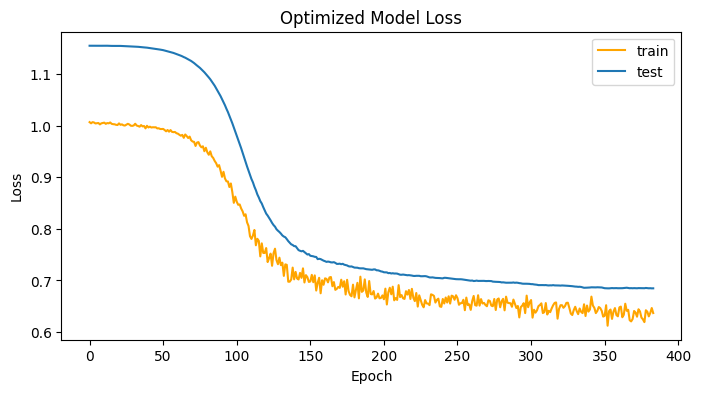

In [35]:
plt.figure(figsize=(8,4))
plt.plot(hist.history['loss'], color = 'orange')
plt.plot(hist.history['val_loss'])
plt.title('Optimized Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [36]:
#Se realiza prediccion
results = best_model.predict(X_test)

results = results.reshape(shape_y_test)
y_grafico = Y_test.reshape(shape_y_test)

19/19 [==============================] - 1s 3ms/step


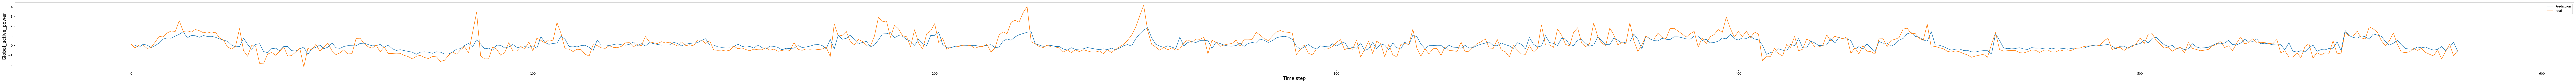

In [37]:
#Grafico de prediccion con el valor real
tiempo=[x for x in range(y_grafico.shape[0])]
plt.figure(figsize=(150,4))
plt.plot(tiempo,results)
plt.ylabel('Global_active_power', size=15)
plt.plot(tiempo,y_grafico)
plt.xlabel('Time step', size=15)
plt.legend(['Prediccion','Real'])
plt.show()

In [38]:
#Metricas de precision del modelo keras
score = best_model.evaluate(X_test, Y_test, verbose = 0)
print('MSE:', score[1])
print('RMSE:', score[2])
print('MAE:', score[3])
print('MAPE:', score[4])

MSE: 0.4739971160888672
RMSE: 0.6884744763374329
MAE: 0.5033652186393738
MAPE: 181.63388061523438


#Exportar resultados

Se guardan los resultados la optimizacion bayesiana

In [39]:
#Del objeto all_results donde estan los resultados de cada trial de la optimizacion bayesiana se obtiene los parametros para exportalos a un csv
results=[]
trial=0 #Nº de intento de optimizacion bayesiana

for result in all_results:
  k=0 #validacion cruzada
  trial+=1
  i=0
  for time in result['time']:
    k+=1
    nameModel = "LSTM_Wallmart" + "_"+str(trial)+"_"+str(k)  + "_"+str(result['params']['epochs'])+"_"+str(result['params']['batch_size'])+"_"+str(result['params']['layers'])+"_"+str(result['params']['neurons'])+"_"+str(round(result['params']['dropout'],2))+"_"+str(result['params']['optimizer'])+"_"+str(result['params']['learning_rate'])
    results.append([nameModel,trial,k,time,
                    result['scores_test'][i][0],result['scores_test'][i][2],result['scores_test'][i][3],result['scores_test'][i][4]]
                   )
    i+=1

In [40]:
#Se crea dataframe
results_csv=pd.DataFrame(results,columns=['nameModel','trial_optimizacion_bayesiana','Step_validacion','time','MSE','RMSE','MAE','MAPE'])

In [41]:
5+5

10

In [42]:
results_csv

,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
0,LSTM_Wallmart_1_1_800_90.0_1.0_192.0_0.54_adam...,1,1,4.890073,0.855706,0.925044,0.702630,119.397453
1,LSTM_Wallmart_1_2_800_90.0_1.0_192.0_0.54_adam...,1,2,29.629158,0.560046,0.748362,0.586950,197.779007
2,LSTM_Wallmart_1_3_800_90.0_1.0_192.0_0.54_adam...,1,3,24.312413,0.529866,0.727919,0.559318,174.578339
3,LSTM_Wallmart_1_4_800_90.0_1.0_192.0_0.54_adam...,1,4,41.132848,0.474331,0.688717,0.514661,197.286575
4,LSTM_Wallmart_1_5_800_90.0_1.0_192.0_0.54_adam...,1,5,92.807222,0.453069,0.673104,0.500708,213.212509
...,...,...,...,...,...,...,...,...
245,LSTM_Wallmart_50_1_800_50.0_3.0_64.0_0.57_adam...,50,1,10.850062,0.853510,0.923856,0.701271,101.761131
246,LSTM_Wallmart_50_2_800_50.0_3.0_64.0_0.57_adam...,50,2,123.028367,0.553999,0.744311,0.544921,177.256958
247,LSTM_Wallmart_50_3_800_50.0_3.0_64.0_0.57_adam...,50,3,160.103420,0.489423,0.699588,0.525570,187.635406
248,LSTM_Wallmart_50_4_800_50.0_3.0_64.0_0.57_adam...,50,4,123.143724,0.503533,0.709601,0.531957,173.398621


In [43]:
results_o = results_csv.sort_values(by='MSE', ascending=True)
results_o.head(5)

,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
14,LSTM_Wallmart_3_5_800_30.0_2.0_352.0_0.43_adam...,3,5,138.101536,0.438978,0.662554,0.487419,228.010025
84,LSTM_Wallmart_17_5_800_30.0_3.0_448.0_0.42_ada...,17,5,233.119091,0.439021,0.662587,0.483972,232.810699
179,LSTM_Wallmart_36_5_800_20.0_2.0_288.0_0.6_adam...,36,5,307.499170,0.439200,0.662722,0.484254,218.693298
74,LSTM_Wallmart_15_5_800_70.0_3.0_512.0_0.5_adam...,15,5,182.062378,0.439808,0.663180,0.481646,211.900406
194,LSTM_Wallmart_39_5_800_40.0_2.0_288.0_0.59_ada...,39,5,228.578541,0.440231,0.663499,0.484051,209.963104


In [48]:
results_csv["time"].mean()

87.7121532421112

In [49]:
# Exportar el DataFrame como CSV
results_csv.to_csv('results_LSTM_Wallmart.csv')

Se guarda cada modelo keras en un objeto Json

In [45]:
import os
# Ruta de la carpeta que deseas crear
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos/Narmax_result_LSTM'

# Verificar si la carpeta ya existe
if not os.path.exists(carpeta_destino):
    # Crear la carpeta si no existe
    os.makedirs(carpeta_destino)

In [46]:
#Del objeto all_results donde estan los resultados de cada trial de la optimizacion bayesiana se obtiene los modelos para exportalos a un Json
results=[]
trial=0 #Nº de intento de optimizacion bayesiana

for result in all_results:
  k=0 #validacion cruzada
  trial+=1
  i=0
  for model in result['models']:
    k+=1
    nameModel = "LSTM_Wallmart"+"_"+str(trial)+"_"+str(k) + "_"+str(result['params']['epochs'])+"_"+str(result['params']['batch_size'])+"_"+str(result['params']['layers'])+"_"+str(result['params']['neurons'])+"_"+str(round(result['params']['dropout'],2))+"_"+str(result['params']['optimizer'])+"_"+str(result['params']['learning_rate'])
    model_json = model.to_json()
    ruta = os.path.join(carpeta_destino, nameModel + ".json")
    with open(ruta, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    save_w=nameModel+"."+"h5"
    weights_path = os.path.join(carpeta_destino, save_w)
    model.save_weights(weights_path)
    i+=1